-LangSmith

-tools & custom tools

-Checkpoint

-Super steps


![super-step Node.png](<attachment:super-step Node.png>)
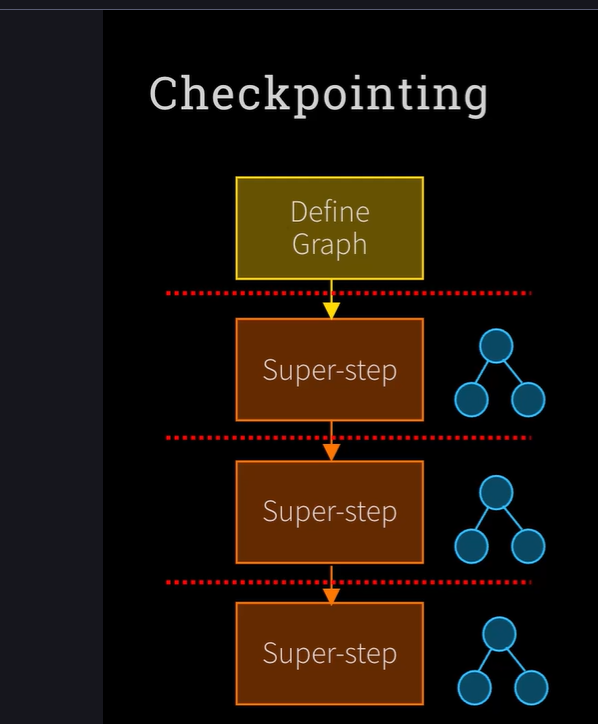


- **LangSmith**: A platform or tool that helps you manage and monitor AI workflows and experiments, making it easier to track and debug how your AI models work.

- **Tools & custom tools**: These are extra functions or features you can add to your AI system, like a search tool or a notification sender. "Custom tools" means you can create your own special functions for your needs.

- **Checkpoint**: A saved state or snapshot of your AI workflow at a certain point, so you can go back to it later if needed, or recover from errors.

- **Super steps**: Think of these as big steps in your AI workflow, where several actions or nodes might happen together in one round of processing.


- **LangSmith**: LangSmith is a platform designed to help you manage, monitor, and debug AI workflows. It provides tools for tracking experiments, visualizing the flow of data and decisions, and understanding how your AI models interact with different components. This makes it easier to identify issues, optimize performance, and ensure reproducibility in your AI projects.

- **Tools & custom tools**: Tools are additional functionalities that can be integrated into your AI workflow, such as search engines, notification systems, or data processors. Custom tools are user-defined functions or modules that address specific needs in your workflow. By creating custom tools, you can extend the capabilities of your AI system to handle unique tasks or integrate with external services.

- **Checkpoint**: A checkpoint is a saved snapshot of your workflow's state at a particular moment. Checkpoints allow you to pause and resume workflows, recover from errors, or experiment with different approaches without losing progress. In LangGraph, checkpoints are essential for managing state across multiple steps and ensuring that you can revert to previous states if needed.

- **Super steps**: Super steps represent a single iteration over the nodes in your workflow graph. During a super step, all nodes that can run in parallel are executed together, while sequential nodes are processed in separate super steps. This concept helps organize complex workflows by grouping related actions and managing the flow of information between different parts of the graph.

###  - more LangGraph..

In [ ]:
!pip install -U langchain langchain-openai

In [ ]:
!pip install langchain_community

In [45]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict


In [46]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


True

### First, let's go set up LangSmith!

https://langsmith.com

### Next, here is a useful function in LangChain community:

In [47]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of india?")

'New Delhi is the capital of India and a part of the National Capital Territory of Delhi (NCT). New Delhi is the seat of all three branches of the Government ... New Delhi, national capital of India. It is situated in the north-central part of the country on the west bank of the Yamuna River. Delhi, officially the National Capital Territory (NCT) of Delhi, is a city and a union territory of India containing New Delhi, the capital of India. A Delhi B Mumbai C Calcutta D Agra लिखित उत्तर Verified by Experts The correct Answer is:A Delhi is the capital of India. noun the capital of India is a division of the old city of Delhi synonyms: Indian capital, New Delhi Delhi is a city and national capital territory in north-central India. The city of Delhi actually consists of two components: Old Delhi, in the north, ... If you are asked what the capital of India is, your answer will be New Delhi, which was settled by the British. New Delhi, the capital of India, represents a palimpsest of over 3

### Now here is a LangChain wrapper class for converting functions into Tools

In [48]:
from langchain.agents import Tool

tool_search =Tool(
        name="search",
        func=serper.run,
        description="Useful for when you need more information from an online search"
    )



### Now we can try out the tool the langchain way

In [49]:
tool_search.invoke("What is the capital of india?")

'New Delhi, national capital of India. It is situated in the north-central part of the country on the west bank of the Yamuna River. Delhi, officially the National Capital Territory (NCT) of Delhi, is a city and a union territory of India containing New Delhi, the capital of India. A Delhi B Mumbai C Calcutta D Agra लिखित उत्तर Verified by Experts The correct Answer is:A Delhi is the capital of India. noun the capital of India is a division of the old city of Delhi synonyms: Indian capital, New Delhi If you are asked what the capital of India is, your answer will be New Delhi, which was settled by the British. Delhi is a city and national capital territory in north-central India. The city of Delhi actually consists of two components: Old Delhi, in the north, ... The capital of India is New Delhi, located in the north-central part of the country to the west of the Yamuna River. Calcutta (now Kolkata, the ... New Delhi, the capital of India, represents a palimpsest of over 3,500 years of

### And now let's write a tool ourselves

We'll pick a familiar one

In [50]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

In [ ]:
tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

tool_push.invoke("Hello, me")

### Back to the Graph from yesterday

One small change - using TypedDict instead of BaseModel for the State object

When we implement tools, we always need to make 2 changes to the code:

1. Changes to provide the tools to OpenAI in json when we make the call

2. Changes to handle the results back: look for the model staying that the finish_reason=="tool_calls" and then retrieve the call, run the function, provide the results.

### Bring them together

In [51]:
tools = [tool_search, tool_push]

In [52]:
# Step 1: Define the State object
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [53]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [54]:
# This is different:

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [55]:
# Step 3: Create a Node


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

* In LangGraph, a "node" is a function that processes part of the workflow.*
* Here, we define a chatbot node that takes the current state (which includes the conversation messages),*
* sends those messages to the language model (llm_with_tools), and returns the updated messages.*

def chatbot(state: State):

    # Print the current state for better understanding and debugging
   
    print("Current state:", state)
    
    # Use the language model (with tools) to process the conversation so far
    # The model will decide if it needs to call a tool or just respond
    
    response = llm_with_tools.invoke(state["messages"])
    
    # Return the new state with the model's response added to the messages list
    
    return {"messages": [response]} 

* Add the chatbot node to the graph*

graph_builder.add_node("chatbot", chatbot)

* Add a tools node to the graph, which handles tool calls*
* ToolNode is a special node that knows how to run the tools we defined earlier*

graph_builder.add_node("tools", ToolNode(tools=tools))

In [56]:
# Step 4: Create Edges


graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

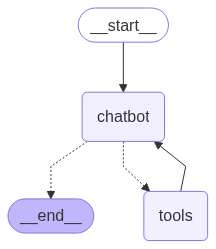

In [57]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

The LangGraph workflow you've built is a directed graph where each node represents a step in the conversational AI process. Here’s how it works:

### Nodes and Flow
- **Nodes:**  
    - `chatbot`: Handles user input, sends messages to the language model (LLM), and decides if a tool should be called.
    - `tools`: Executes any tool (like search or push notification) requested by the LLM.

- **Edges (Flow):**
    1. The graph starts at the `chatbot` node (`START → chatbot`).
    2. The `chatbot` node processes the current state (messages). If the LLM decides a tool is needed, the flow conditionally moves to the `tools` node.
    3. After a tool is executed, the flow returns to the `chatbot` node for further processing or response.
    4. This loop continues until the conversation is complete.

### How Does It End Automatically?
- The graph ends when the LLM produces a response that does **not** require any tool calls.  
- At this point, the `tools_condition` function (used in `add_conditional_edges`) determines there are no more tool calls, so the graph does not transition to the `tools` node again.
- The graph then reaches the `END` state, and the super-step (one round of message processing) is complete.

### Summary
- **Start:** User input triggers the graph at `chatbot`.
- **Loop:** `chatbot` → (if tool needed) `tools` → `chatbot` (repeat as needed).
- **End:** When no tool is needed, the graph stops and returns the final response.

This design allows for dynamic, multi-step conversations where the LLM can use tools as needed, and the workflow ends automatically when the conversation is resolved.

### That's it! And, let's do this:

In [58]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7867
* To create a public link, set `share=True` in `launch()`.


## OK it's time to add Memory!

### BUT WAIT!

We have this whole Graph maintaining the state and appending to the state.

Why isn't this handling memory?

### This is a crucial point for understanding LangGraph

> A super-step can be considered a single iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.


One "Super-Step" of the graph represents one invocation of passing messages between agents.

In idomatic LangGraph, you call invoke to run your graph for each super-step; for each interaction.

The reducer handles state updates automatically within one super-step, but not between them.

That is what checkpointing achieves.

In [59]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

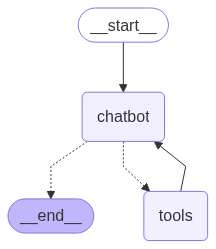

In [60]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [61]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7868
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi ', additional_kwargs={}, response_metadata={}, id='ce217b58-2d22-4a47-976a-2b6e642ffc06')]}
{'messages': [HumanMessage(content='hi ', additional_kwargs={}, response_metadata={}, id='ce217b58-2d22-4a47-976a-2b6e642ffc06'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 90, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BnPINEefz8lvmomG2wg9ScjQ24xVc', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--eef89a66-82ad-42fc-9531-90d34aed21e6-0', usage_metadata={'input_tokens': 90, 'output_tokens': 10, 'total_tokens': 100, 'input_token

In [62]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='hi ', additional_kwargs={}, response_metadata={}, id='ce217b58-2d22-4a47-976a-2b6e642ffc06'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 90, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BnPINEefz8lvmomG2wg9ScjQ24xVc', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--eef89a66-82ad-42fc-9531-90d34aed21e6-0', usage_metadata={'input_tokens': 90, 'output_tokens': 10, 'total_tokens': 100, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage

In [63]:
# Most recent first

list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='hi ', additional_kwargs={}, response_metadata={}, id='ce217b58-2d22-4a47-976a-2b6e642ffc06'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 90, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BnPINEefz8lvmomG2wg9ScjQ24xVc', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--eef89a66-82ad-42fc-9531-90d34aed21e6-0', usage_metadata={'input_tokens': 90, 'output_tokens': 10, 'total_tokens': 100, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessag

### LangGraph gives you tools to set the state back to a prior point in time, to branch off:

```
config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)
```

And this allows you to build stable systems that can be recovered and rerun from any prior checkpoint.

### And now let's store in SQL

### And this is the power of LangGraph.

In [65]:
!pip install langgraph.checkpoint.sqlite

In [66]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

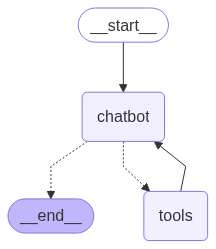

In [67]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))
 

In [68]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7869
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='09ec9082-4e0a-4f4e-bd96-948f90907f76')]}
{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='09ec9082-4e0a-4f4e-bd96-948f90907f76'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 89, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BnPRP5gEbuBHRRenngdzInITKf6Aj', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--23702341-75e7-4eb0-bdb2-a5459bef5f4e-0', usage_metadata={'input_tokens': 89, 'output_tokens': 10, 'total_tokens': 99, 'input_token_det